# Modern Art: ARTGAN 

**Author:** Andrea Murphy

**Description:** Modern art created using generative adversarial network (GAN) as an art medium. Inspired by a few of  my favorite artists.   


In [1]:
import numpy as np 
import pandas as pd

import os, sys
from IPython.display import display
from IPython.display import Image as _Imgdis
from PIL import Image, ImageOps
import numpy as np
from time import time
from time import sleep
import matplotlib.pyplot as plt

import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Reshape, Conv2D, Conv2DTranspose, Flatten, Dropout
from tensorflow.keras.preprocessing import image

import random 

Working with 1905 images
Image examples: 
Edgar_Degas_191.jpg 

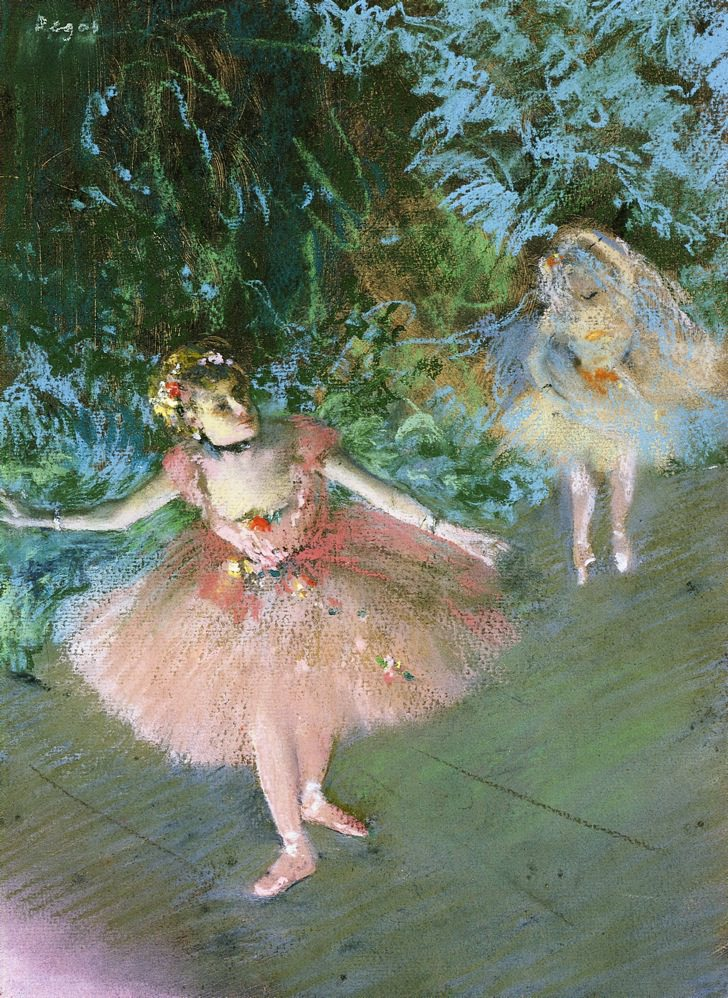

Vincent_van_Gogh_751.jpg 

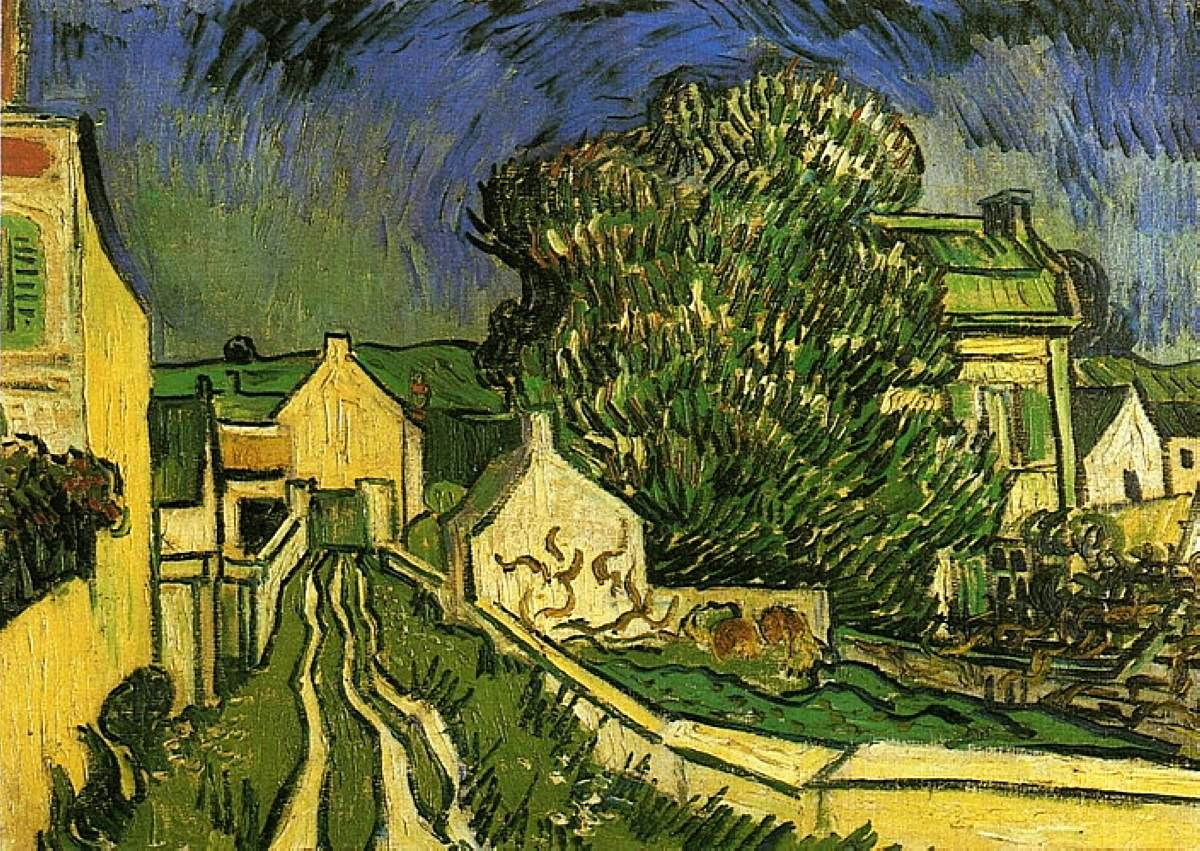

Edgar_Degas_50.jpg 

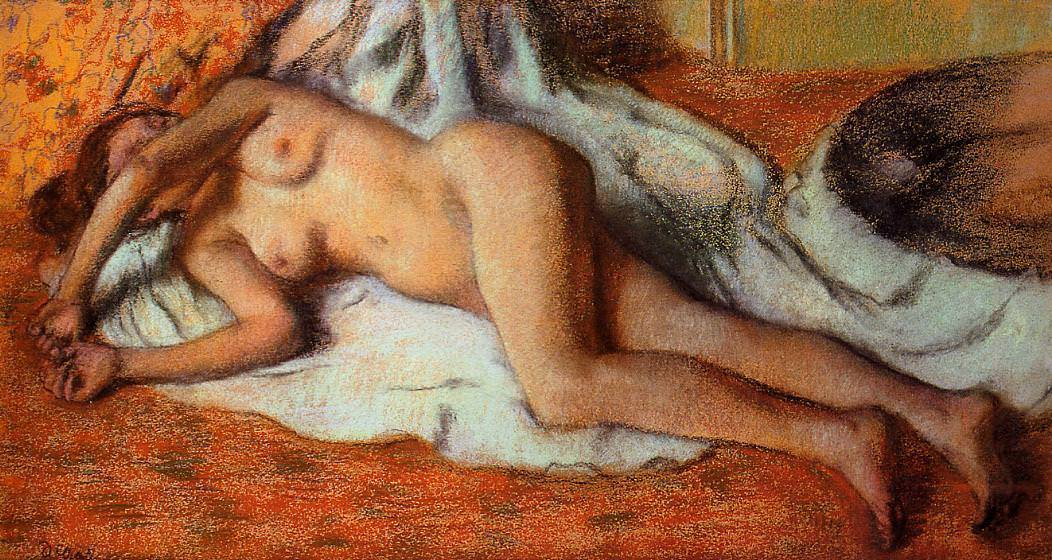

Vincent_van_Gogh_560.jpg 

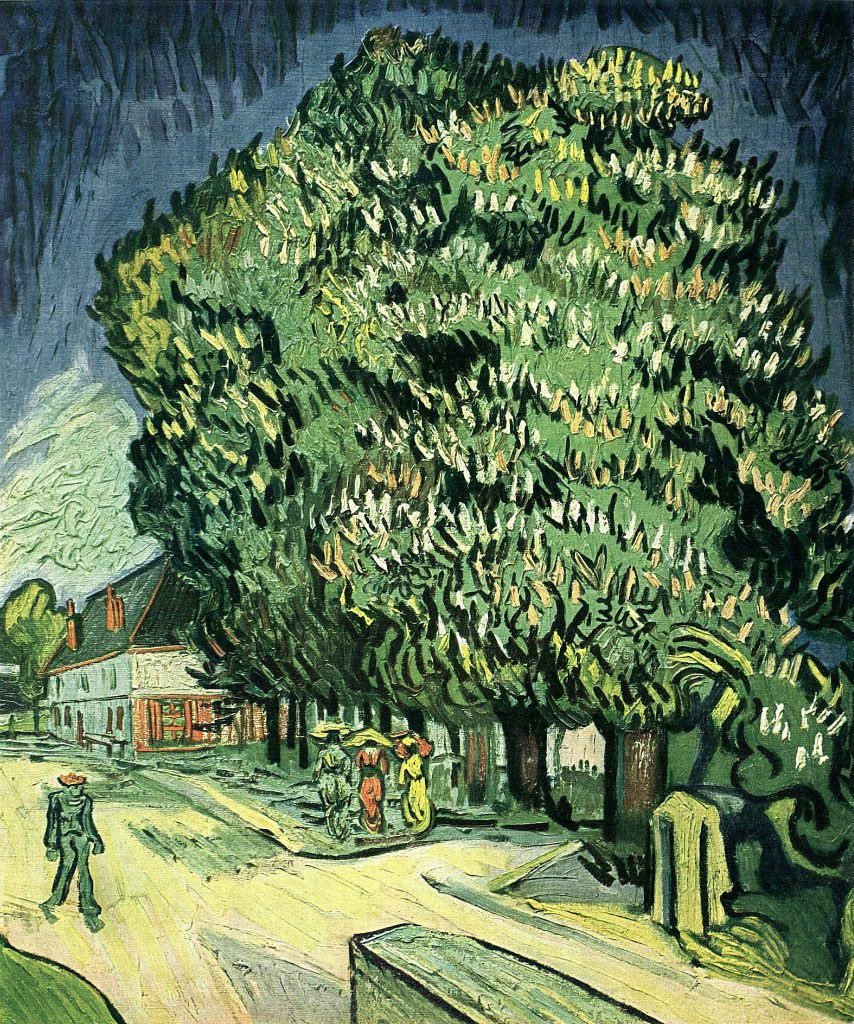

Vincent_van_Gogh_66.jpg 

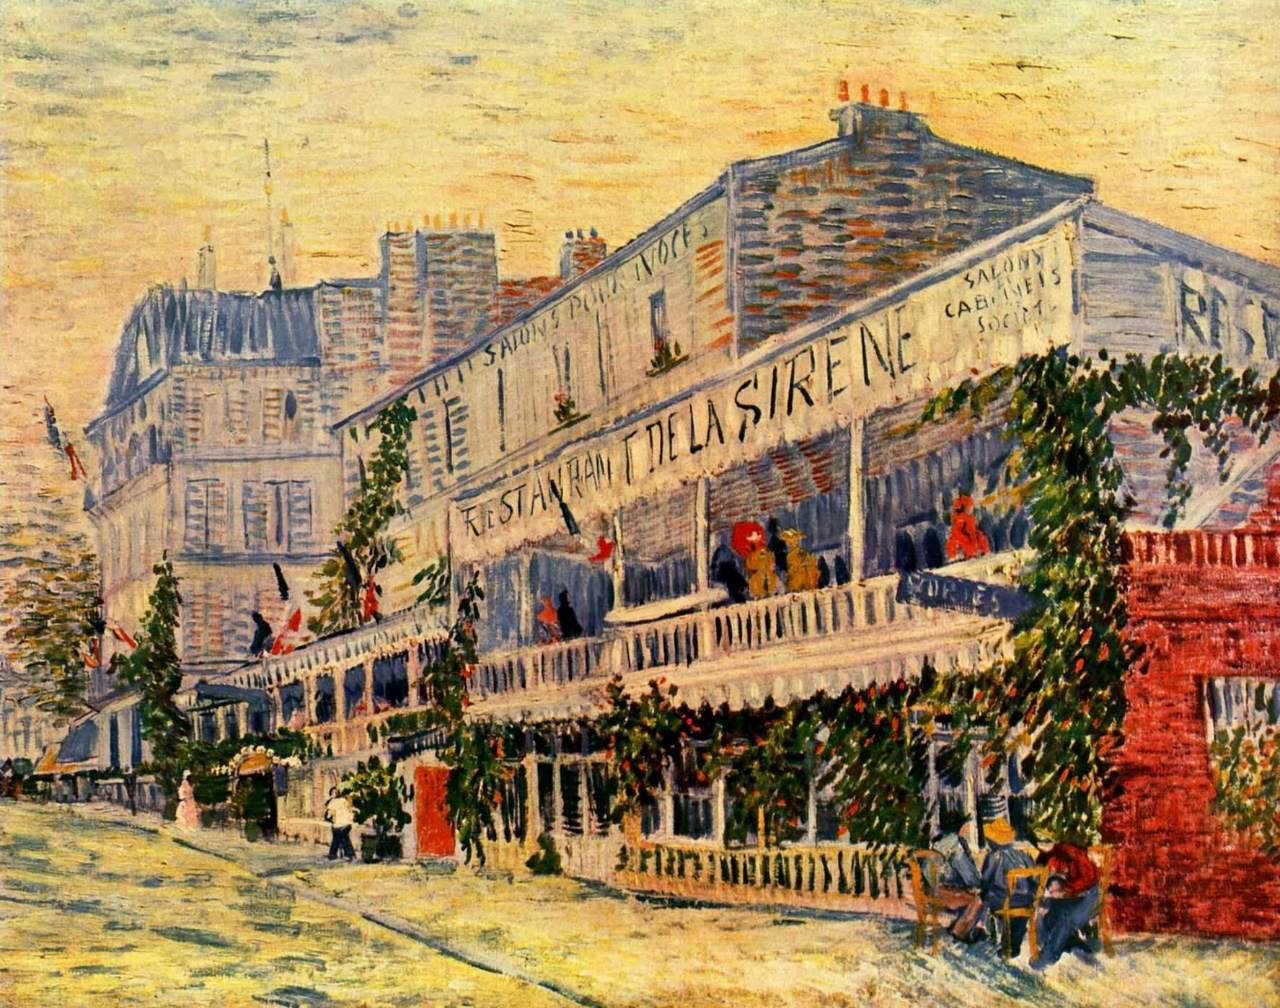

In [2]:
folder = "Edvard_Munch/"

onlyfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

print("Working with {0} images".format(len(onlyfiles)))
print("Image examples: ")


for r in random.sample(range(0, 1905), 5):
    print(onlyfiles[r], end=" ")
    display(_Imgdis(filename=folder + "/" + onlyfiles[r], width=240, height=320))

In [3]:
DIM = 32 # The Models dimensionality
height = 32
width = 32
channels = 3
#OUTPUT_DIM = 64*64*3 # The number of pixels in each iamge

## The Generator

In [4]:
generator_input = Input(shape=(DIM))

x = Dense(128 * 16 * 16)(generator_input)
x = LeakyReLU()(x)
x = Reshape((16, 16, 128))(x)

x = Conv2D(256, 5, padding='same')(x)
x = LeakyReLU()(x)

x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = LeakyReLU()(x)

x = Conv2D(256, 5, padding='same')(x)
x = LeakyReLU()(x)
x = Conv2D(256, 5, padding='same')(x)
x = LeakyReLU()(x)

x = Conv2D(channels, 7, activation='tanh', padding='same')(x)

generator = Model(inputs=generator_input, outputs=x)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


## The Discriminator

In [5]:
disc_input = Input(shape=(height, width, channels))
x = Conv2D(128, 3)(disc_input)
x = LeakyReLU()(x)
x = Conv2D(128, 4, strides=2)(x)
x = LeakyReLU()(x)
x = Conv2D(128, 4, strides=2)(x)
x = LeakyReLU()(x)
x = Conv2D(128, 4, strides=2)(x)
x = LeakyReLU()(x)
x = Flatten()(x)
x = Dropout(0.4)(x)
x = Dense(1, activation='sigmoid')(x)

discriminator = Model(inputs=disc_input, outputs=x)

disc_opt = keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=disc_opt, loss='binary_crossentropy')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## The Adversarial

In [6]:
discriminator.trainable = False

gan_input = Input(shape=(DIM))
gan_output = discriminator(generator(gan_input))

gan = Model(inputs=gan_input, outputs=gan_output)
gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

## Image files to Numpy Arrays 

In [7]:
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

train_files = []
y_train = []
i=0
for _file in onlyfiles:
    train_files.append(_file)
    label_in_file = _file.find("_")
    y_train.append(str(_file[0:label_in_file]))
    
print("Files in train_files: %d" % len(train_files))

Files in train_files: 1905


Using TensorFlow backend.


In [8]:
# Original Dimensions
image_width = 32
image_height = 32
ratio = 4

image_width = int(image_width / ratio)
image_height = int(image_height / ratio)

channels = 3
nb_classes = 1

dataset = np.ndarray(shape=(len(onlyfiles), channels, image_height, image_width),
                     dtype=np.float32)


In [9]:
i = 0
for _file in train_files:
    img = load_img(folder + "/" + _file)  # this is a PIL image
    img.thumbnail((image_width, image_height))
    # Convert to Numpy Array
    x = img_to_array(img)

In [ ]:
print(x)

## Split the data for training 

In [10]:
from sklearn.model_selection import train_test_split
 
X_train, X_test, y_train, y_test = train_test_split(dataset, y_train, test_size=0.2)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

print("Train set size: {0}, Val set size: {1}, Test set size: {2}".format(len(X_train), len(X_val), len(X_test)))

Train set size: 1524, Val set size: 191, Test set size: 190


In [11]:
X_train = X_train.astype('float32') / 255

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [12]:
iterations = 100
batch_size = 20
save_dir = './Star_date2'

if not os.path.isdir(save_dir):
    os.mkdir(save_dir)

start = 0
for step in range(iterations):
    random_latent_vectors = np.random.normal(size=(batch_size, DIM))
    
    generated_images = generator.predict(random_latent_vectors)
    stop = start + batch_size
    real_images = X_train[start: stop]
    
    print(f"generated_images: {generated_images[0].shape}")
    print(f"real_images:{ real_images[0].shape}")
    print(f"step:{step}")
    
    combined_images = np.concatenate([generated_images, real_images])
    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    labels += 0.05 * np.random.random(labels.shape)
    
    # train discriminator
    d_loss = discriminator.train_on_batch(combined_images, labels)
    random_latent_vectors = np.random.normal(size=(batch_size, DIM))
    
    # train generator
    misleading_targets = np.zeros((batch_size, 1))  
    a_loss = gan.train_on_batch(random_latent_vectors,
                               misleading_targets)  
    start += batch_size
    if start > len(X_train) - batch_size:
        start = 0
        
    if step % 100 == 0:
        gan.save_weights('gan.1')
        
        print('discriminator loss:', d_loss)
        print('adversarial loss:', a_loss)
        
        img = image.array_to_img(generated_images[0] * 255, scale=False)
        img.save(os.path.join(save_dir, 'generated_image' + str(step) + '.png'))
        
        img = image.array_to_img(real_images[0] * 255, scale=False)
        img.save(os.path.join(save_dir, 'real_image' + str(step) + '.png'))

generated_images: (32, 32, 3)
real_images:(3, 8, 8)
step:0


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 32 and the array at index 1 has size 3

In [ ]:
figsize=(16, 6)
plt.imshow(plt.imread('./Star_date2/generated_image0.png'))

plt.show()
plt.imshow(plt.imread('./Star_date2/real_image0.png'))

In [ ]:
img = image.array_to_img(generated_images[1] * 255, scale=False)
img.save(os.path.join(save_dir, 'generated_image' + str(step) + '.png'))
        
img = image.array_to_img(real_images[1] * 255, scale=False)
img.save(os.path.join(save_dir, 'real_image' + str(step) + '.png'))

In [ ]:
figsize=(16, 6)
plt.imshow(plt.imread('./Star_date2/generated_image2.png'))

plt.show()
plt.imshow(plt.imread('./Star_date2/real_image2.png'))